In [1]:
%matplotlib inline

In [2]:
import random
import pandas as pd
import matplotlib.pylab as pl

In [3]:
import cadCAD
from cadCAD import engine
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [4]:
simulation_parameters = {
    'T': range(20),
    'N': 1,
    'M': {}
}

# Test of Basic Design

In [5]:
# general constants

TIMESTEP = 'timestep' # access to current timestep with s[TIMESTEP]

In [6]:
def get_update_name(variable_name):
    return "add_" + variable_name

In [7]:
USERS = "users"
PATS = "pats"
OPATS = "opats"
CLAIMS = "claims"
ADD_USERS = get_update_name(USERS)
ADD_PATS = get_update_name(PATS)
ADD_OPATS = get_update_name(OPATS)
ADD_CLAIMS = get_update_name(CLAIMS)
WALLET_GAINS = "wallet_gains"

In [8]:
initial_conditions = {
    USERS: {0:{}}, # users are numerical ids and a dictionary of their current wallet
    PATS: [0], # pats are currently simply numerical ids
}

## update functions

In [9]:
# create single user with empty wallet 
def create_users(params, step, sL, s):
    next_user_id = len(s[USERS])
    x = {ADD_USERS:[
        (next_user_id, {}),
         #{random.choice(s[PATS]):random.randint(1,10)}
    ]}
    return x

In [10]:
def create_pat(params, step, sL, s):
    next_pat_id = len(s[PATS])
    x = {ADD_PATS:[next_pat_id,]}
    return x

In [11]:
def user_actions(params, step, sL, s):
    gain = {}
    pats = s[PATS]
    for user in s[USERS]:
        for pat in random.sample(pats, random.randint(0, len(pats))):
            gain[(user, pat)] = 1
    return {WALLET_GAINS: gain}

## update variables

In [12]:
def add_users(params, step, sL, s, _input):
    x = s[USERS].copy()
    for new_user_id, wallet in _input[ADD_USERS]:
        x[new_user_id] = wallet
    return (USERS, x)

In [13]:
def update_user_wallets(params, step, sL, s, _input):
    x = s[USERS].copy()
    changes = _input[WALLET_GAINS]
    for (user, pat), gain in changes.items():
        x[user][pat] = x[user].get(pat, 0) + gain
    return (USERS, x)

In [14]:
def add_pat(params, step, sL, s, _input):
    x = s[PATS].copy()
    x.extend(_input[ADD_PATS])
    return (PATS, x)    

## test of basic functions

In [15]:
partial_state_update_blocks = [
    { 
        'policies': { 
            'create_users': create_users,
        },
        'variables': { 
            USERS: add_users,
        }
    },
    { 
        'policies': {
            'user_actions': user_actions,
        },
        'variables': {
            USERS: update_user_wallets,
        }
    },
    { 
        'policies': {
            'create_pat': create_pat,
        },
        'variables': {
            PATS: add_pat,
        }
    },    
]

config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute()

df = pd.DataFrame(raw_result)
print(df)

single_proc: [<cadCAD.configuration.Configuration object at 0x7f5cde6f7668>]
                                                 pats  run  substep  timestep  \
0                                                 [0]    1        0         0   
1                                                 [0]    1        1         1   
2                                                 [0]    1        2         1   
3                                              [0, 1]    1        3         1   
4                                              [0, 1]    1        1         2   
5                                              [0, 1]    1        2         2   
6                                           [0, 1, 2]    1        3         2   
7                                           [0, 1, 2]    1        1         3   
8                                           [0, 1, 2]    1        2         3   
9                                        [0, 1, 2, 3]    1        3         3   
10                              

# Initial design V0

In [34]:
initial_conditions = {
    USERS: {0:{}}, # users are numerical ids and a dictionary of their current wallet
    PATS: [0], # pats are currently simply numerical ids
    CLAIMS: {},
}

In [41]:
def users_join(params, step, sL, s):
    """Each step one user joins the system"""
    next_user_id = len(s[USERS])
    x = {ADD_USERS:[
        (next_user_id, {}),
    ]}
    return x

def claim_pat(params, step, sL, s):
    """Each step each user creates a random amount of claims for a random selection of PATs"""
    maximum_number_of_actions = 10
    new_claims = {}
    pats = s[PATS]
    for user in s[USERS]:
        for pat in random.sample(pats, random.randint(0, min(len(pats), maximum_number_of_actions))):
            new_claims[(user, pat)] = 1
    return ({ADD_CLAIMS: new_claims})

def prove_claim(params, step, sL, s):
    """Each steps all claims are accepted with a certain probability"""
    acceptance_probability = 1
    gains = {}
    for (user, pat), gain in s[CLAIMS].items():
        if random.random() < acceptance_probability:
            gains[(user, pat)] = gain
    
    return {WALLET_GAINS:gains}

def create_new_pats(params, step, sL, s):
    """Each step one new PAT is added to the system"""
    next_pat_id = len(s[PATS])
    x = {ADD_PATS:[next_pat_id,]}
    return x

In [69]:
def update_users(params, step, sL, s, _input):
    x = s[USERS] 
    
    # add new users
    for new_user_id, wallet in _input[ADD_USERS]:
        x[new_user_id] = wallet
    
    # update wallet according to proven claims
    changes = _input[WALLET_GAINS]
    for (user, pat), gain in changes.items():
        x[user][pat] = x[user].get(pat, 0) + gain
        
    return (USERS, x)

def update_pats(params, step, sL, s, _input):
    x = s[PATS] 
    x.extend(_input[ADD_PATS])
    return (PATS, x)

def update_claims(params, step, sL, s, _input):
    return (CLAIMS, _input[ADD_CLAIMS])

In [70]:
# Initial Design V0
partial_state_update_blocks = [
    { 
        'policies': { 
            'users_join': users_join,
            'claim_pats': claim_pat,
            'prove_claim': prove_claim,
            'create_new_pats': create_new_pats
        },
        'variables': { 
            USERS: update_users,
            PATS: update_pats,
            CLAIMS: update_claims, 
        }
    },
]

In [92]:
simulation_parameters = {
    'T': range(100), 
    'N': 1,
    'M': {}
}

In [93]:
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute()

df = pd.DataFrame(raw_result)
#print(df)
print(raw_result[-1])

single_proc: [<cadCAD.configuration.Configuration object at 0x7f5cb14e4748>]
{'claims': {(0, 62): 1, (1, 4): 1, (1, 33): 1, (1, 68): 1, (2, 48): 1, (2, 12): 1, (2, 62): 1, (3, 49): 1, (3, 74): 1, (3, 21): 1, (3, 41): 1, (3, 38): 1, (3, 15): 1, (3, 93): 1, (3, 88): 1, (3, 17): 1, (6, 55): 1, (7, 17): 1, (7, 38): 1, (7, 75): 1, (7, 40): 1, (7, 73): 1, (7, 96): 1, (7, 91): 1, (7, 86): 1, (7, 94): 1, (8, 31): 1, (8, 12): 1, (8, 33): 1, (9, 35): 1, (9, 47): 1, (9, 67): 1, (9, 10): 1, (9, 72): 1, (10, 59): 1, (10, 93): 1, (10, 15): 1, (11, 2): 1, (11, 22): 1, (11, 58): 1, (11, 82): 1, (11, 70): 1, (11, 97): 1, (11, 86): 1, (11, 48): 1, (11, 91): 1, (11, 56): 1, (12, 65): 1, (12, 63): 1, (12, 44): 1, (12, 1): 1, (12, 15): 1, (12, 56): 1, (12, 37): 1, (12, 50): 1, (12, 61): 1, (13, 20): 1, (13, 41): 1, (13, 71): 1, (13, 73): 1, (13, 22): 1, (14, 87): 1, (14, 38): 1, (14, 67): 1, (14, 44): 1, (14, 27): 1, (15, 38): 1, (15, 59): 1, (15, 25): 1, (15, 68): 1, (15, 15): 1, (15, 79): 1, (15, 29): 1,

# Analysis
- Too many different Pats with too little token/activity per PAT
- Multiple of same kind

{0: 474, 1: 482, 2: 445, 3: 452, 4: 482, 5: 461, 6: 473, 7: 491, 8: 454, 9: 463, 10: 439, 11: 483, 12: 433, 13: 454, 14: 465, 15: 409, 16: 428, 17: 400, 18: 378, 19: 414, 20: 410, 21: 438, 22: 377, 23: 407, 24: 377, 25: 387, 26: 356, 27: 360, 28: 335, 29: 368, 30: 359, 31: 320, 32: 353, 33: 320, 34: 346, 35: 319, 36: 314, 37: 338, 38: 332, 39: 280, 40: 295, 41: 289, 42: 274, 43: 287, 44: 274, 45: 279, 46: 274, 47: 289, 48: 238, 49: 270, 50: 264, 51: 234, 52: 231, 53: 256, 54: 236, 55: 209, 56: 227, 57: 192, 58: 216, 59: 183, 60: 202, 61: 208, 62: 180, 63: 202, 64: 187, 65: 167, 66: 167, 67: 157, 68: 150, 69: 161, 70: 136, 71: 142, 72: 120, 73: 142, 74: 130, 75: 94, 76: 124, 77: 92, 78: 127, 79: 86, 80: 83, 81: 86, 82: 84, 83: 84, 84: 69, 85: 78, 86: 67, 87: 60, 88: 56, 89: 54, 90: 45, 91: 26, 92: 28, 93: 32, 94: 29, 95: 27, 96: 15, 97: 13, 98: 9, 99: 0, 100: 0}


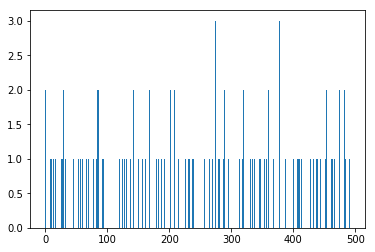

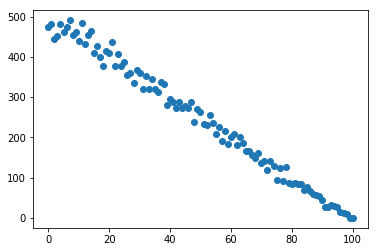

In [97]:
def calculate_total_tokens_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            distribution[pat] += number_of_tokens
    return distribution

print(calculate_total_tokens_per_pat(raw_result[-1]))
pl.hist(calculate_total_tokens_per_pat(raw_result[-1]).values(), bins=300)
pl.show()

pl.scatter(calculate_total_tokens_per_pat(raw_result[-1]).keys(), 
           calculate_total_tokens_per_pat(raw_result[-1]).values())

{0: 84, 1: 81, 2: 85, 3: 78, 4: 87, 5: 85, 6: 85, 7: 83, 8: 85, 9: 85, 10: 82, 11: 85, 12: 82, 13: 82, 14: 86, 15: 86, 16: 84, 17: 87, 18: 81, 19: 81, 20: 85, 21: 83, 22: 84, 23: 84, 24: 81, 25: 84, 26: 81, 27: 80, 28: 86, 29: 83, 30: 86, 31: 86, 32: 80, 33: 80, 34: 86, 35: 85, 36: 83, 37: 88, 38: 86, 39: 84, 40: 86, 41: 83, 42: 81, 43: 85, 44: 83, 45: 87, 46: 80, 47: 84, 48: 86, 49: 87, 50: 88, 51: 84, 52: 80, 53: 86, 54: 79, 55: 79, 56: 82, 57: 82, 58: 77, 59: 78, 60: 81, 61: 80, 62: 82, 63: 78, 64: 80, 65: 77, 66: 75, 67: 76, 68: 74, 69: 76, 70: 70, 71: 73, 72: 74, 73: 81, 74: 75, 75: 57, 76: 72, 77: 60, 78: 68, 79: 60, 80: 55, 81: 62, 82: 56, 83: 62, 84: 52, 85: 60, 86: 51, 87: 48, 88: 43, 89: 44, 90: 37, 91: 23, 92: 22, 93: 29, 94: 28, 95: 25, 96: 15, 97: 12, 98: 9, 99: 0, 100: 0}


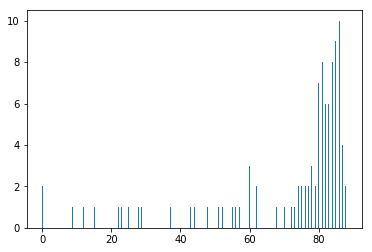

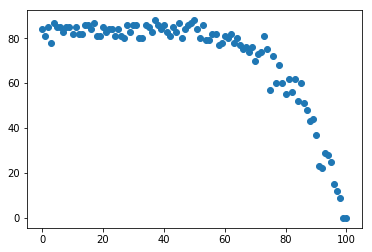

In [95]:
def calculate_active_user_per_pat(state):
    distribution = {pat:0 for pat in state[PATS]}
    for user_wallet in state[USERS].values():
        for pat, number_of_tokens in user_wallet.items():
            distribution[pat] += 1
    return distribution

print(calculate_active_user_per_pat(raw_result[-1]))
pl.hist(calculate_active_user_per_pat(raw_result[-1]).values(), bins=300)
pl.show()

pl.scatter(calculate_active_user_per_pat(raw_result[-1]).keys(), 
           calculate_active_user_per_pat(raw_result[-1]).values())

[86, 85, 82, 85, 87, 84, 84, 84, 81, 81, 82, 83, 83, 85, 81, 84, 82, 79, 86, 82, 83, 84, 85, 89, 82, 81, 86, 79, 85, 83, 91, 83, 79, 82, 82, 82, 84, 83, 84, 84, 81, 76, 91, 82, 83, 84, 83, 86, 86, 74, 80, 85, 84, 82, 81, 81, 80, 79, 84, 82, 83, 80, 80, 75, 77, 81, 79, 77, 82, 83, 82, 77, 63, 71, 71, 70, 65, 66, 69, 60, 53, 59, 56, 66, 60, 51, 52, 52, 44, 49, 40, 32, 26, 31, 25, 16, 12, 6, 6, 0, 0]


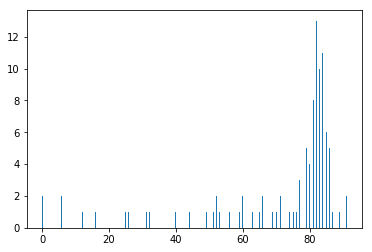

In [96]:
def calculate_distributions_of_number_of_tokens(state):
    distribution = []
    for user_wallet in state[USERS].values():
        distribution.append(len(user_wallet))
    return distribution

print(calculate_distributions_of_number_of_tokens(raw_result[-1]))
pl.hist(calculate_distributions_of_number_of_tokens(raw_result[-1]), bins=300)
pl.show()

# New Design (V1)
- Req: Concentration/Focus/Emphasis on good PATs
- Proposal: List of accepted/good/official PATs (using TCR -> new Token GOV)
- Initial Approach, 1 GOV per User (democracy, one vote for each user)

In [106]:
initial_conditions = {
    USERS: {0:{}}, # users are numerical ids and a dictionary of their current wallet
    PATS: [0], # pats are currently simply numerical ids
    OPATS: [],
    CLAIMS: {},
}

In [162]:
def claim_pat_with_opats(params, step, sL, s):
    """Each step each user creates a random amount of claims for a random selection of PATs"""
    maximum_number_of_actions = 10
    probability_on_opat_actions = .9
    new_claims = {}
    pats = s[PATS]
    opats = s[OPATS]

    for user in s[USERS]:
        number_of_actions = random.randint(0, min(len(pats), maximum_number_of_actions))
        opat_actions = min(len(opats), int(number_of_actions*probability_on_opat_actions))
        usual_actions = number_of_actions - opat_actions
        
        for pat in random.sample(opats, opat_actions):
            new_claims[(user, pat)] = 1
        
        for pat in random.sample(pats, random.randint(0, usual_actions)):
            new_claims[(user, pat)] = 1
    return ({ADD_CLAIMS: new_claims})

def propose_opats(params, step, sL, s):
    if 5 < s[TIMESTEP] < 20:
        proposal_probability = .5
    else: 
        proposal_probability = .01
    pats = s[PATS]
    opats = s[OPATS]
    new_opats = []
    if random.random() < proposal_probability:
        next_opat = random.choice(pats)
        
        i = 0
        while next_opat in opats:
            i += 1
            if i >= 10:
                break
            next_opat = random.choice(pats)
        else:
            new_opats.append(next_opat)
    
    return {ADD_OPATS:new_opats}

In [163]:
def update_opats(params, step, sL, s, _input):
    x = s[OPATS]
    x.extend(_input[ADD_OPATS])
    return (OPATS, x)

In [164]:
# Design V1 with 
partial_state_update_blocks = [
    { 
        'policies': { 
            'users_join': users_join,
            'claim_pats': claim_pat_with_opats,
            'prove_claim': prove_claim,
            'create_new_pats': create_new_pats,
            'propose_opats': propose_opats,
        },
        'variables': { 
            USERS: update_users,
            PATS: update_pats,
            CLAIMS: update_claims, 
            OPATS: update_opats,
        }
    },
]

In [165]:
simulation_parameters = {
    'T': range(100), 
    'N': 1,
    'M': {}
}

In [166]:
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute()

df = pd.DataFrame(raw_result)
#print(df)
print(raw_result[-1])

single_proc: [<cadCAD.configuration.Configuration object at 0x7f5cb1b47f28>]
{'claims': {(0, 5): 1, (0, 1): 1, (0, 6): 1, (0, 8): 1, (0, 42): 1, (1, 9): 1, (1, 3): 1, (3, 42): 1, (3, 0): 1, (3, 5): 1, (3, 1): 1, (3, 8): 1, (3, 6): 1, (3, 3): 1, (3, 19): 1, (4, 6): 1, (5, 9): 1, (5, 42): 1, (5, 0): 1, (5, 19): 1, (6, 8): 1, (6, 42): 1, (6, 1): 1, (6, 19): 1, (7, 19): 1, (7, 42): 1, (7, 6): 1, (7, 9): 1, (7, 8): 1, (7, 5): 1, (8, 0): 1, (8, 42): 1, (8, 9): 1, (8, 19): 1, (8, 3): 1, (8, 5): 1, (10, 19): 1, (10, 6): 1, (10, 1): 1, (10, 5): 1, (10, 0): 1, (10, 42): 1, (10, 9): 1, (10, 3): 1, (10, 8): 1, (11, 42): 1, (11, 9): 1, (11, 1): 1, (11, 8): 1, (11, 5): 1, (11, 19): 1, (11, 3): 1, (11, 6): 1, (11, 0): 1, (12, 1): 1, (12, 42): 1, (12, 6): 1, (12, 9): 1, (12, 23): 1, (13, 42): 1, (14, 0): 1, (14, 9): 1, (14, 42): 1, (14, 8): 1, (14, 6): 1, (14, 19): 1, (14, 3): 1, (14, 5): 1, (14, 77): 1, (15, 3): 1, (15, 0): 1, (15, 9): 1, (15, 2): 1, (16, 3): 1, (16, 5): 1, (16, 8): 1, (16, 1): 1, (1

# Analysis

{0: 2377, 1: 2438, 2: 61, 3: 2399, 4: 49, 5: 2433, 6: 2367, 7: 57, 8: 2415, 9: 2315, 10: 54, 11: 44, 12: 52, 13: 48, 14: 34, 15: 41, 16: 34, 17: 45, 18: 38, 19: 2319, 20: 35, 21: 41, 22: 45, 23: 35, 24: 31, 25: 30, 26: 28, 27: 39, 28: 22, 29: 43, 30: 40, 31: 45, 32: 33, 33: 18, 34: 27, 35: 29, 36: 27, 37: 30, 38: 37, 39: 35, 40: 28, 41: 26, 42: 758, 43: 21, 44: 26, 45: 22, 46: 24, 47: 28, 48: 14, 49: 19, 50: 27, 51: 21, 52: 23, 53: 24, 54: 13, 55: 26, 56: 15, 57: 23, 58: 23, 59: 9, 60: 16, 61: 21, 62: 16, 63: 21, 64: 14, 65: 11, 66: 19, 67: 13, 68: 17, 69: 12, 70: 21, 71: 6, 72: 21, 73: 11, 74: 7, 75: 14, 76: 2, 77: 12, 78: 16, 79: 5, 80: 10, 81: 5, 82: 8, 83: 8, 84: 4, 85: 5, 86: 12, 87: 7, 88: 3, 89: 7, 90: 2, 91: 2, 92: 2, 93: 0, 94: 1, 95: 2, 96: 2, 97: 2, 98: 1, 99: 0, 100: 0}


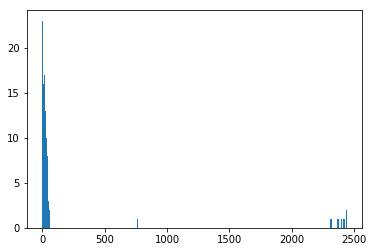

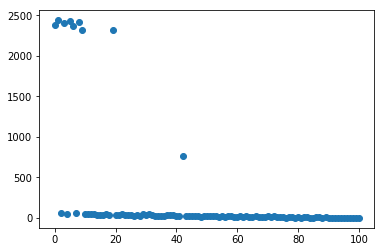

In [167]:
print(calculate_total_tokens_per_pat(raw_result[-1]))
pl.hist(calculate_total_tokens_per_pat(raw_result[-1]).values(), bins=300)
pl.show()

pl.scatter(calculate_total_tokens_per_pat(raw_result[-1]).keys(), 
           calculate_total_tokens_per_pat(raw_result[-1]).values())

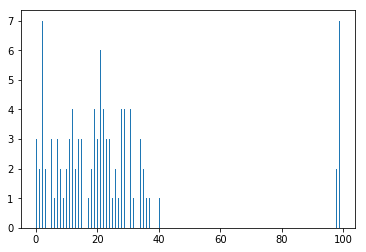

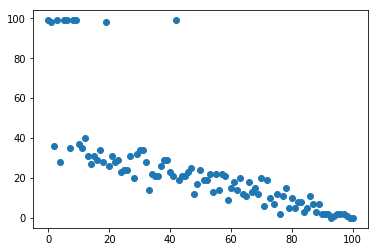

In [168]:
pl.hist(calculate_active_user_per_pat(raw_result[-1]).values(), bins=300)
pl.show()

pl.scatter(calculate_active_user_per_pat(raw_result[-1]).keys(), 
           calculate_active_user_per_pat(raw_result[-1]).values())

[37, 37, 38, 31, 35, 33, 39, 34, 31, 37, 31, 33, 37, 33, 38, 38, 36, 34, 35, 36, 36, 27, 31, 33, 34, 34, 30, 30, 29, 36, 32, 27, 33, 33, 35, 30, 31, 34, 33, 30, 26, 29, 23, 31, 29, 27, 28, 25, 24, 24, 23, 21, 25, 23, 31, 25, 22, 32, 28, 23, 21, 19, 25, 22, 23, 25, 24, 22, 20, 19, 22, 20, 19, 17, 20, 21, 19, 21, 14, 18, 15, 15, 14, 18, 14, 16, 13, 14, 11, 13, 12, 13, 15, 9, 8, 11, 10, 9, 8, 0, 0]


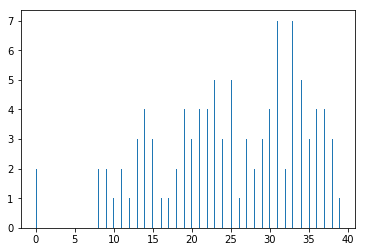

In [169]:
print(calculate_distributions_of_number_of_tokens(raw_result[-1]))
pl.hist(calculate_distributions_of_number_of_tokens(raw_result[-1]), bins=300)
pl.show()

# Analysis
- It could work??
- Vulnerability: Sybil attack
- #Req: Introduction of REP as "Proof-of-work" for user actions

In [ ]:
# new policy functions with REP

In [ ]:
# Design V2 with 
partial_state_update_blocks = [
    { 
        'policies': { 
            'users_join': users_join,
            'claim_pats': claim_pat_with_opats,
            'prove_claim': prove_claim,
            'create_new_pats': create_new_pats
        },
        'variables': { 
            USERS: update_users,
            PATS: update_pats,
            CLAIMS: update_claims, 
        }
    },
    { 
        'policies': { 
            'propose_opats': propose_opats,
            'challenge_opats': challenge_opats,
            'vote_on_opats': vote_on_opats,
        },
        'variables': { 
            'proposals': update_proposals,
            'challenges': update_challenges,
            OPATS: update_opats,
            'failed_proposals': update_failed_proposals,
            'failed_challenges': update_failed_challenges,
        }
    },
]